# NN Classification with Pytorch


## Make Classification Data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

In [ ]:
n_samples = 1000

# Creating Circles
X,Y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 42)

In [ ]:
X.shape, Y.shape

((1000, 2), (1000,))

In [ ]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [ ]:
print(Y[:5])

[1 1 1 1 0]


In [ ]:
# Make DataFrame of Circle Data

In [ ]:
import pandas as pd
# Dictonary
circles = pd.DataFrame(
    {
        'X1': X[:, 0],
        'X2': X[:,1],
        'Lable' : Y
    }
)

circles.head(10)

,X1,X2,Lable
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


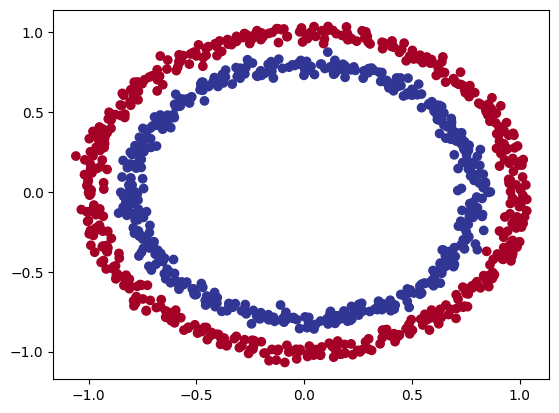

In [ ]:
# Visualize , Visualize

plt.scatter(x = X[:, 0],
            y = X[:,1],
            c = Y,
            cmap = plt.cm.RdYlBu)

In [ ]:
X.shape, Y.shape

((1000, 2), (1000,))

## Get Ready for Tensors

In [ ]:
# Turn dtaa into tensor
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [ ]:
X.dtype, Y.dtype

(dtype('float64'), dtype('int64'))

In [ ]:
type(X), type(Y)

(numpy.ndarray, numpy.ndarray)

In [ ]:
X = torch.from_numpy(X).type(torch.float32)
Y = torch.from_numpy(Y).type(torch.float32)
X.dtype, Y.dtype

(torch.float32, torch.float32)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state= 42)

## Building Model
1. Setup Device Agnosyic code
2. constructr a model
3. DefineLOss function and Optimizer
4. Create a Traning Test Loop


In [ ]:
import torch
from torch import nn


# make Device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Our Model
1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` Layers that are capable of handling tha shapes of our data
3. Define a `Forward ` Method : Forward Pass
4. Instantiate an instance of our model calass and send it to the target

In [ ]:
X_train.shape

torch.Size([800, 2])

In [ ]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Create 2 nn.Linear Layers capable of handing the shape of our data
    self.Layer_1 = nn.Linear(in_features = 2, out_features= 5)
    self.Layer_2 = nn.Linear(in_features = 5, out_features =1)

  def forward(self, x):
    return self.Layer_2(self.Layer_1(x)) # X -> Layer_1 -> Layer_2-> Output


model = CircleModel().to(device)
model


CircleModel(
  (Layer_1): Linear(in_features=2, out_features=5, bias=True)
  (Layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### Replicating model using `nn.Sequential`

In [ ]:
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:

model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5401, -0.6598],
                      [ 0.3108,  0.4949],
                      [-0.0549, -0.4994],
                      [-0.5695,  0.4933],
                      [-0.7010,  0.5903]])),
             ('0.bias', tensor([-0.4566, -0.5739, -0.5975,  0.2670, -0.4939])),
             ('1.weight',
              tensor([[ 0.2232,  0.1927,  0.1594, -0.4198,  0.0087]])),
             ('1.bias', tensor([0.3525]))])

In [ ]:
# Untrained Predictions
untrained_preds = model_1(X_test.to(device))
print(len(untrained_preds))
print(untrained_preds.shape)
print(len(X_test))
print(X_test.shape)
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{Y_test[:10]}")

200
torch.Size([200, 1])
200
torch.Size([200, 2])

First 10 predictions:
tensor([[-0.4510],
        [-0.3855],
        [-0.2510],
        [-0.5092],
        [ 0.3393],
        [ 0.3747],
        [ 0.0915],
        [ 0.2710],
        [-0.2762],
        [-0.3745]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup Loss Function and Optimizer

1.  For Regression we have MSE, MAE
2. For Classification we have Binary Cross Entropy or Categorical Cross Entropy (Cross Entropy).

Optimizer:
1. SGD
2. AdAm

* For Loss we will use `nn.BCELossWithLogits`

`nn.BCELoss` + `torch.sigmoid` = `nn.BCEWithLogitLoss`

In [ ]:
Loss = nn.BCEWithLogitsLoss() # Sigmoid activation is built in
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.01)

### Calculating Accuracy

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
from sklearn.metrics import accuracy_score

### Training a Model
1. for loop Epochs
2. Model.train()
3. y_preds = model(X_train)
4. loss = Loss(y_preds, y_train)
5. optimizer.zero_grad()
6. loss.backward()
7. optimizer.step()
8. Model.eval()
9. y_test_preds = Model(X_test)
10. loss_test = Loss(y_test_preds, y_test)
11. if epoch % 10 == 0:

     with torch.inference_mode()
     
     print(f'Epoch: {epoch} | Loss: {loss}| Test_Loss: {loss_test}')
     


#### Going from raw logits-> Prediction Probabilities -> Predictiooon Labels
* Our Model output are going to be raw **Logits**
* We can convert these **Logits** into **Prediction Probabilities** by pasing them in to some kind of activation functin(e.g. `Sigmoid` for Binary Classification and `Softmax` for Multiclass Classification)
* Then we convert the model's predictions by either rounding them or taking the`argmax()`

* Logits(raw outpurs of thr model) -> pred_Prob(use `torch.sigmoid`) -> labels(take the `torch.round` of the prediction probabilities)

In [ ]:
# Checking the first 5 outputs of the forward pass on the test data
model.eval()
with torch.inference_mode():
  y_logits = model(X_test.to(device))
print(y_logits[:5])

tensor([[0.6069],
        [0.6671],
        [0.4525],
        [0.6507],
        [0.4576]])


In [ ]:
# use the sigmoid activation funcytion on our logits

y_pred_prob = torch.sigmoid(y_logits).squeeze()
print(y_pred_prob[:5])

tensor([0.6472, 0.6608, 0.6112, 0.6572, 0.6124])


For our prediction values, we need to perform a range -style rounding on them:

`y_pred_prob` >= 0.5   `y=1`(Class = 1)

`y_pred_prob` < 0.5   `y=0`(Class = 0)

In [ ]:
y_pred_labels =torch.round(y_pred_prob[:5])

#### Training Loop

In [ ]:
import numpy as np
torch.cuda.manual_seed(42)

epochs = 100
 # put data to target device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)



for epoch in range(epochs):

  ## Trianing
  model.train()
  # 1. Forward Pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  # 2. Loss/ Accuracy
      ## BCEWithLogitsLoss : Expect logits as input
  loss = Loss(y_logits,
              Y_train)
        ## BCELoss: Expects Prediction probabilities as input
  #loss = Loss(torch.sigmoid(y_logits),
  #          Y_train)

  acc = accuracy_score(y_true = Y_train.detach().cpu().numpy(),
                    y_pred = y_pred.detach().cpu().numpy())
  # 3 Optimizer.zero_grad
  optimizer.zero_grad()

  # 4. Loss Backward

  loss.backward()

  # 5. Optimizer step
  optimizer.step()


#### Testing

  model.eval()
  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate test Loss/accuracy
    test_loss = Loss(test_logits,
                     Y_test)

    test_accuracy = accuracy_score(y_true = Y_test.detach().cpu().numpy(),
                                y_pred = test_pred.detach().cpu().numpy())

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test_Loss: {test_loss:.5f} | Test_Accuracy: {test_accuracy}")





Epoch: 0 | Loss: 0.72844 | Accuracy: 0.50% | Test_Loss: 0.73388 | Test_Accuracy: 0.5
Epoch: 10 | Loss: 0.72455 | Accuracy: 0.50% | Test_Loss: 0.72978 | Test_Accuracy: 0.5
Epoch: 20 | Loss: 0.72109 | Accuracy: 0.50% | Test_Loss: 0.72612 | Test_Accuracy: 0.5
Epoch: 30 | Loss: 0.71801 | Accuracy: 0.50% | Test_Loss: 0.72286 | Test_Accuracy: 0.5
Epoch: 40 | Loss: 0.71528 | Accuracy: 0.50% | Test_Loss: 0.71995 | Test_Accuracy: 0.5
Epoch: 50 | Loss: 0.71285 | Accuracy: 0.50% | Test_Loss: 0.71736 | Test_Accuracy: 0.5
Epoch: 60 | Loss: 0.71068 | Accuracy: 0.50% | Test_Loss: 0.71504 | Test_Accuracy: 0.5
Epoch: 70 | Loss: 0.70876 | Accuracy: 0.50% | Test_Loss: 0.71298 | Test_Accuracy: 0.5
Epoch: 80 | Loss: 0.70704 | Accuracy: 0.50% | Test_Loss: 0.71113 | Test_Accuracy: 0.5
Epoch: 90 | Loss: 0.70552 | Accuracy: 0.50% | Test_Loss: 0.70948 | Test_Accuracy: 0.5


In [17]:
## 4. Make Predictions and evaluate the model


# we are importing a function 'plot decission boundary'

import requests
from pathlib import Path

## Download helper function from learn pytorch repo (if it`s already downloadwded)

if Path('helper_function.py').is_file():
  print('File already exists')
else:
  print('Downloading file')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
  with open('helper_function.py', 'wb') as f:
    f.write(request.content)

from helper_function import plot_decision_boundary, plot_predictions

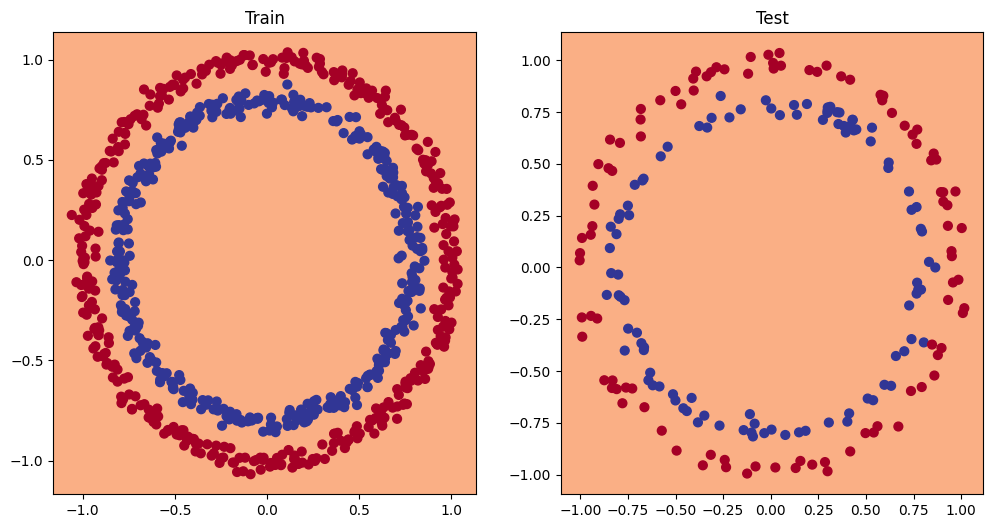

In [ ]:
# Plot Deciion boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model = model,
                        X = X_train,
                        y = Y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model = model,
                        X = X_test,
                        y= Y_test)

### Improving a Model
* Add More Layers
* Add More hidden units - go from 5 hidden units to 10 hidden units
* Changing Activation function
* Change the Learning Rate
* Cahnge the Loss Function



#### New_Model
* Adding more hidden units: 5 -> 10
* Adding more Hidden Layers: 2-> 3
* increase the number of Epochs: 100-> 1000

In [ ]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
# Device Agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
class CircleModel_V1(nn.Module):
  def __init__(self):
    super().__init__()
    self.Layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.Layer_2 = nn.Linear(in_features = 10, out_features= 16)
    self.Layer_3 = nn.Linear(in_features = 16, out_features = 1)


  def forward(self, x):
    return self.Layer_3(self.Layer_2(self.Layer_1(x)))



In [ ]:
modelV1 = CircleModel_V1().to(device)
modelV1

CircleModel_V1(
  (Layer_1): Linear(in_features=2, out_features=10, bias=True)
  (Layer_2): Linear(in_features=10, out_features=16, bias=True)
  (Layer_3): Linear(in_features=16, out_features=1, bias=True)
)

In [ ]:
## Creating Loss and Optimizer

Loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params:= modelV1.parameters(),
                             lr = 0.1)


In [ ]:
## Writing the training and evaluation code
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Put data on the target device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)


epochs = 1001

for epoch in range(epochs):
  modelV1.train()
  # 1. Forward Pass
  y_logits = modelV1(X_train).squeeze()
  y_pred_prob = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_prob)
  # 2. Loss and Accuracy
  loss = Loss(y_logits, Y_train)
  acc = accuracy_score(y_true = Y_train.detach().numpy(),
                       y_pred = y_pred.detach().numpy())

  # 3. Optimizer.zero_grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step()
  optimizer.step()


  modelV1.eval()
  with torch.inference_mode():
    test_logits = modelV1(X_test).squeeze()
    test_pred_prob = torch.sigmoid(test_logits)
    test_pred = torch.round(test_pred_prob)

    test_loss = Loss(test_logits, Y_test)
    test_acc = accuracy_score(y_true = Y_test.detach().numpy(),
                              y_pred= test_pred.detach().numpy())

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test_Loss: {test_loss:.5f} | Test_Accuracy: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.70673 | Accuracy: 0.50% | Test_Loss: 0.71323 | Test_Accuracy: 0.50%
Epoch: 100 | Loss: 0.69302 | Accuracy: 0.51% | Test_Loss: 0.69552 | Test_Accuracy: 0.47%
Epoch: 200 | Loss: 0.69298 | Accuracy: 0.51% | Test_Loss: 0.69482 | Test_Accuracy: 0.46%
Epoch: 300 | Loss: 0.69298 | Accuracy: 0.52% | Test_Loss: 0.69471 | Test_Accuracy: 0.45%
Epoch: 400 | Loss: 0.69298 | Accuracy: 0.51% | Test_Loss: 0.69468 | Test_Accuracy: 0.45%
Epoch: 500 | Loss: 0.69298 | Accuracy: 0.51% | Test_Loss: 0.69468 | Test_Accuracy: 0.46%
Epoch: 600 | Loss: 0.69298 | Accuracy: 0.51% | Test_Loss: 0.69468 | Test_Accuracy: 0.46%
Epoch: 700 | Loss: 0.69298 | Accuracy: 0.51% | Test_Loss: 0.69468 | Test_Accuracy: 0.46%
Epoch: 800 | Loss: 0.69298 | Accuracy: 0.51% | Test_Loss: 0.69468 | Test_Accuracy: 0.46%
Epoch: 900 | Loss: 0.69298 | Accuracy: 0.51% | Test_Loss: 0.69468 | Test_Accuracy: 0.46%
Epoch: 1000 | Loss: 0.69298 | Accuracy: 0.51% | Test_Loss: 0.69468 | Test_Accuracy: 0.46%


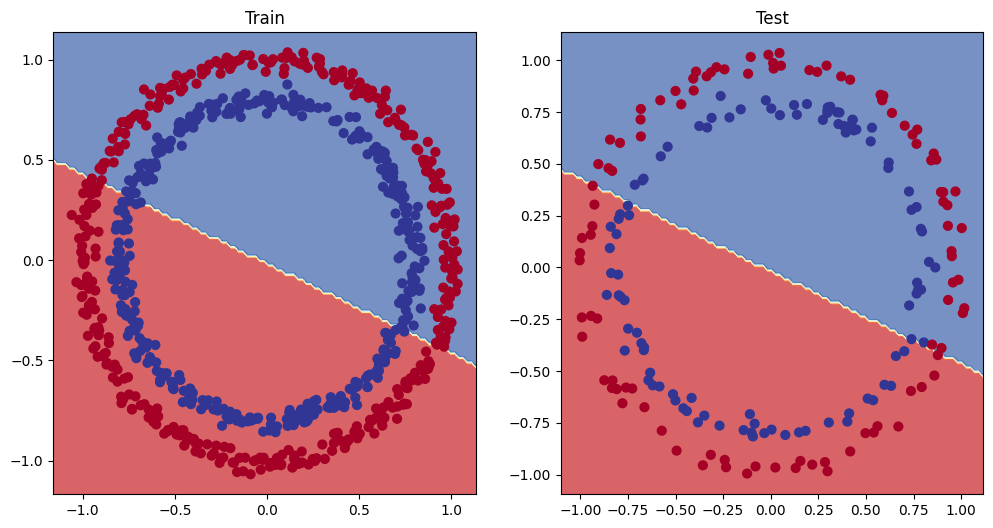

In [ ]:
# Plot Deciion boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model = modelV1,
                        X = X_train,
                        y = Y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model = modelV1,
                        X = X_test,
                        y= Y_test)

#### Preparing data to see if our model can fit a straight line ?
one way to troubleshoot to a larger problem is to test out a smaller problem

In [ ]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# create data:
weight = 0.7
bias = 0.3

X_line = torch.arange(0,1,0.01).unsqueeze(dim =1)
Y_line = weight * X_line + bias
print(len(X_line))
print(X_line[:5])
print(Y_line[:5])

100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]])
tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [ ]:
# Splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X_line, Y_line, test_size = 0.2, random_state= 42)

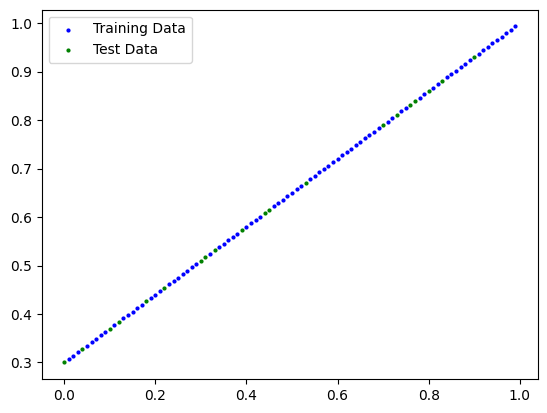

In [ ]:
# Visualize Visualize
plt.scatter(X_train, Y_train, c = 'b', s = 4, label = 'Training Data')
plt.scatter(X_test, Y_test, c = 'g', s = 4, label = 'Test Data')
plt.legend()
plt.show()

In [ ]:
## Model
class Model_test(nn.Module):
  def __init__(self):
    super().__init__()
    self.Layer_1 = nn.Linear(in_features=1, out_features = 10)
    self.Layer_2 = nn.Linear(in_features = 10, out_features = 10)
    self.Layer_3 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self, x):
    return self.Layer_3(self.Layer_2(self.Layer_1(x)))


In [ ]:
## Model Instance
model_t = Model_test().to(device)
model_t

Model_test(
  (Layer_1): Linear(in_features=1, out_features=10, bias=True)
  (Layer_2): Linear(in_features=10, out_features=10, bias=True)
  (Layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
## Defining Loss and Optimizer
Loss = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_t.parameters(), lr = 0.001)

In [ ]:
# Training and Testing Loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 1. Move data to the device
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)


# 2. Training Loop
epochs = 1001
for epoch in range(epochs):
    # Training Phase
    model_t.train()
    # 3. Forward Pass
    y_pred = model_t(X_train)

    # 4. Loss Calculation and Accuracy
    loss = Loss(y_pred, Y_train)

    # 5. Optimizer.zero_grad()
    optimizer.zero_grad()

    # 6. Backward Pass
    loss.backward()

    # 7. Optimizer Step
    optimizer.step()

    # Testing Phase
    model_t.eval()
    with torch.inference_mode():
        # 8. Forward Pass
        test_pred = model_t(X_test)  # Raw logits
        # 9. Loss Calculation and Accuracy Calculation
        test_loss = Loss(test_pred, Y_test)  # BCEWithLogitsLoss expects logits
    # Logging every 100 epochs
    if epoch % 100 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f} | Test_Loss: {test_loss:.5f} ")


Epoch: 0 | Loss: 0.80353 | Test_Loss: 0.77528 
Epoch: 100 | Loss: 0.41583 | Test_Loss: 0.39712 
Epoch: 200 | Loss: 0.02830 | Test_Loss: 0.02202 
Epoch: 300 | Loss: 0.00263 | Test_Loss: 0.00142 
Epoch: 400 | Loss: 0.00246 | Test_Loss: 0.00158 
Epoch: 500 | Loss: 0.00228 | Test_Loss: 0.00174 
Epoch: 600 | Loss: 0.00211 | Test_Loss: 0.00190 
Epoch: 700 | Loss: 0.00193 | Test_Loss: 0.00205 
Epoch: 800 | Loss: 0.00176 | Test_Loss: 0.00221 
Epoch: 900 | Loss: 0.00159 | Test_Loss: 0.00237 
Epoch: 1000 | Loss: 0.00141 | Test_Loss: 0.00253 


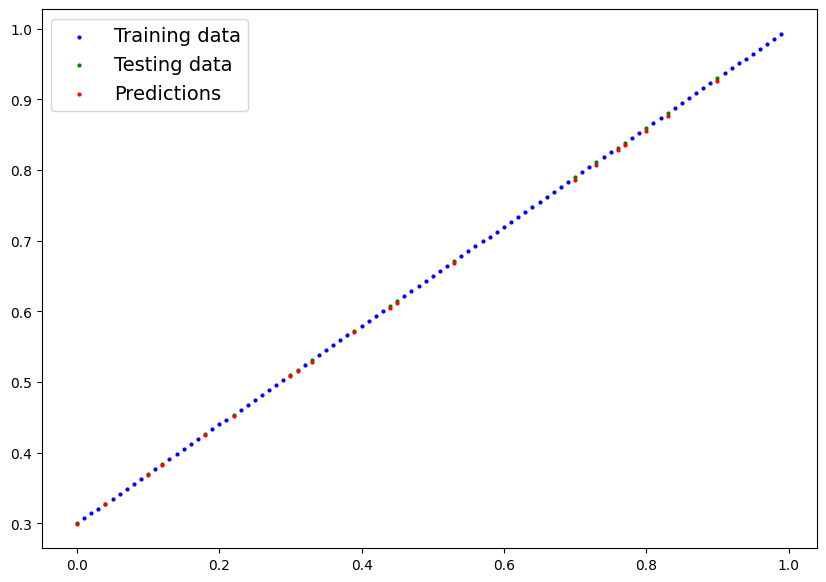

In [ ]:
from helper_function import plot_predictions

plot_predictions(train_data= X_train ,
                 train_labels= Y_train,
                 test_data = X_test,
                 test_labels= Y_test,
                 predictions = test_pred)

#### The Missing piece:  Non-Linearity

"what pattern could you draw if you were given a infinite  amount of straight and non- straight line"

or in machine learning terms, an infinite(but really it is finite) of linear and non-linear functions?


##### Recreating non linear data(red and blue circles)

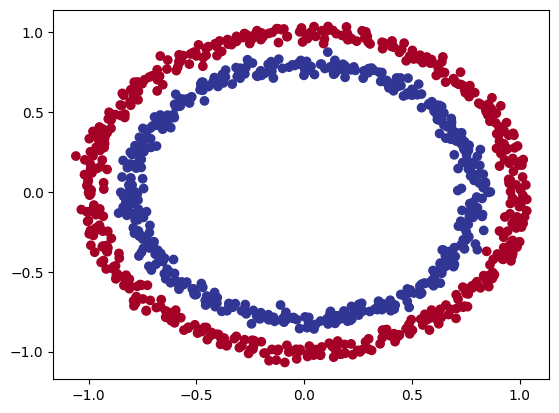

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data set
from sklearn.datasets import make_circles

n_samples = 1000

X, Y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

plt.scatter(X[:,0],
            X[:,1],
            c=Y,
            cmap = plt.cm.RdYlBu)
plt.show()

In [ ]:
type(X), type(Y)

# convert it into the tensors

X = torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.float)

type(X), type(Y)

(torch.Tensor, torch.Tensor)

In [ ]:
# splitting the data set
X_train, X_test, Y_train, Y_test =  train_test_split(X,Y, test_size = 0.2, random_state = 42)

# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### Building Model with Non-Linearity
* Using Non Linear activvation function

In [ ]:
class CircleModel_V2(nn.Module):
  def __init__(self):
    super().__init__()
    self.Layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.Layer_2 = nn.Linear(in_features = 10 , out_features = 10)
    self.Layer_3 = nn.Linear(in_features = 10, out_features = 1)
    self.relu = nn.ReLU() #  Activation functions

  def forward(self, x):
    return self.Layer_3(self.relu(self.Layer_2(self.relu(self.Layer_1(x)))))


model_V3 = CircleModel_V2().to(device)
model_V3





CircleModel_V2(
  (Layer_1): Linear(in_features=2, out_features=10, bias=True)
  (Layer_2): Linear(in_features=10, out_features=10, bias=True)
  (Layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# moving the tensor to the dvice
X_train, Y_train  = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

# definig Loss function and Optimizer
Loss = nn.BCEWithLogitsLoss() # requires Logits as input
optimizer = torch.optim.SGD(params = model_V3.parameters(), lr = 0.1)

#Training Loop

epochs = 1401

for epoch in range(epochs):
  model_V3.train()
  # 1. Forward Pass
  y_logits = model_V3(X_train).squeeze()
  y_prob = torch.sigmoid(y_logits)
  y_preds = torch.round(y_prob)

  # 2. Loss Calculatipon and accuracy
  loss = Loss(y_logits, Y_train)
  acc = accuracy_score(y_true = Y_train.detach().numpy(),
                       y_pred = y_preds.detach().numpy())*100

  # 3. optimzer.zero_grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5 optimizer step()
  optimizer.step()

  model_V3.eval()
  with torch.inference_mode():
    # Forward PAss
    test_logits = model_V3(X_test).squeeze()
    test_prob = torch.sigmoid(test_logits)
    test_preds = torch.round(test_prob)

    # LossCalculation and accuracy
    test_loss = Loss(test_logits, Y_test)
    test_acc = accuracy_score(y_true = Y_test,
                              y_pred = test_preds)*100

    if epoch %  100 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.4f} | Training accuracy: {acc:.2f}% | Testing Loss: {test_loss:.4f} | testing accuracy: {test_acc:.2f}%')




Epoch: 0 | Loss: 0.6978 | Training accuracy: 50.25% | Testing Loss: 0.6954 | testing accuracy: 51.50%
Epoch: 100 | Loss: 0.6921 | Training accuracy: 53.50% | Testing Loss: 0.6917 | testing accuracy: 54.50%
Epoch: 200 | Loss: 0.6893 | Training accuracy: 54.25% | Testing Loss: 0.6899 | testing accuracy: 55.00%
Epoch: 300 | Loss: 0.6864 | Training accuracy: 63.25% | Testing Loss: 0.6881 | testing accuracy: 65.50%
Epoch: 400 | Loss: 0.6830 | Training accuracy: 65.00% | Testing Loss: 0.6856 | testing accuracy: 62.50%
Epoch: 500 | Loss: 0.6780 | Training accuracy: 65.38% | Testing Loss: 0.6812 | testing accuracy: 65.50%
Epoch: 600 | Loss: 0.6703 | Training accuracy: 67.62% | Testing Loss: 0.6748 | testing accuracy: 67.50%
Epoch: 700 | Loss: 0.6577 | Training accuracy: 70.38% | Testing Loss: 0.6639 | testing accuracy: 70.00%
Epoch: 800 | Loss: 0.6330 | Training accuracy: 85.12% | Testing Loss: 0.6425 | testing accuracy: 81.50%
Epoch: 900 | Loss: 0.5861 | Training accuracy: 96.88% | Testing Lo

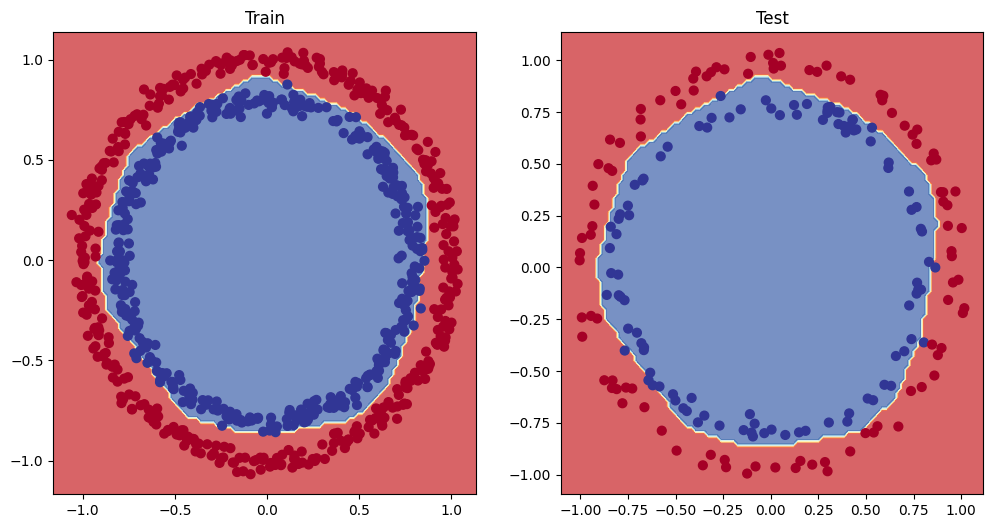

In [ ]:
from helper_function import plot_decision_boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model = model_V3,
                        X = X_train,
                        y = Y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model = model_V3,
                        X = X_test,
                        y= Y_test)


# Multiclass Classification

## Putting it all together with a multiclass classifiation
* Binary Classification = One thing or another (cat vs. dog, Spam VS. not spam, fraud vs. not fraud)
* Multi-class Classification = more than one thing or another(cat vs dog vs chicken)

## Creating a toy multiclass data set

In [1]:
# import dependicies
import torch
from torch import nn
import matplotlib.pyplot as plt
# Sklearn libraries
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


### Data set

In [2]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42
SAMPLES = 1000


X_blob, Y_blob = make_blobs(n_samples = SAMPLES,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,
                            random_state= RANDOM_SEED)


#### WEare making dataset fom the sklear and it uses numpy so we have to conver our data set to the tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
Y_blob = torch.from_numpy(Y_blob).type(torch.float)
print(type(X_blob))
print(type(Y_blob))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815],
        [-6.7941, -6.4772],
        [ 5.2102,  2.8890],
        [-5.5051, -6.3604],
        [-6.5438, -4.8339],
        [ 6.4496,  0.7478]])
tensor([3., 2., 2., 1., 1., 2., 1., 2., 2., 1.])


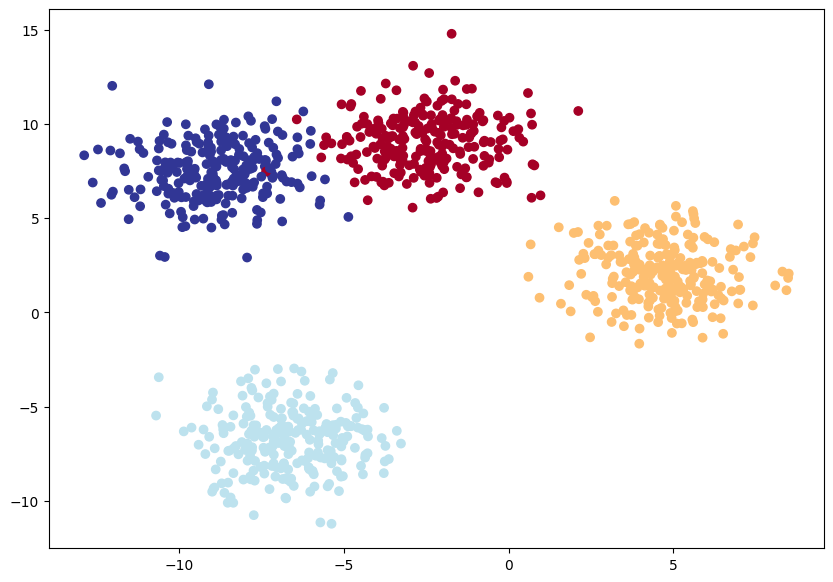

In [3]:
### Visualize Visualize
print(X_blob[:10])
print(Y_blob[:10])

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],
            X_blob[:,1],
            c = Y_blob,
            cmap = plt.cm.RdYlBu)
plt.show()

In [4]:
# Splitting the data set in 80:20

X_train, X_test, Y_train, Y_test = train_test_split(X_blob, Y_blob, test_size = 0.2, random_state = 42)

In [5]:
# Creating device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

X_train, Y_train = X_train.to(device), Y_train.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

In [6]:
# Model Creation
class MultiClass_Model(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    '''
    ## Iinitialize the multiclass model:
    Args:
        input_features(init) : Number o finput features to the model
        output_features (int): Number of outputs features (Number of output classes)
        hidden_units (int): Number of hidden units between layers , default = 8

    Returns:

    Example:
    '''
    super().__init__()
    self.Linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features= hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.Linear_layer_stack(x)



In [7]:
model_V4 = MultiClass_Model(input_features = 2,
                            output_features =4,
                            hidden_units = 8
                            ).to(device)
model_V4

MultiClass_Model(
  (Linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [8]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, torch.unique(Y_train)

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]),
 tensor([0., 1., 2., 3.]))

In [9]:
## LOss function and optimizer
Loss = nn.CrossEntropyLoss() # For C Class  and when the classes are imbalanced then we can use the `weight parameter inside it`
optimizer = torch.optim.SGD(params = model_V4.parameters(), lr = 0.1)

#### Getting prediction probabilities for a multi-class PyTorch model

* in order to evaluate and train and test our model, we need to convert our model`s outputs(logits) to predictions probabilities and then to prediction labels.

* Logits(raw outpurs of thr model) -> pred_Prob(use `torch.softmax`) -> labels(take the `torch.argmax` of the prediction probabilities)

In [10]:
y_logits = model_V4(X_train)
y_logits[:10]

tensor([[-0.5105,  0.1007,  0.6611, -0.3977],
        [-0.7911, -0.1059,  0.2399, -0.6706],
        [-0.4434, -0.2729,  0.8368, -0.5289],
        [-0.3456, -0.1132,  0.6499, -0.2192],
        [-0.8723, -0.1462,  0.2727, -0.5570],
        [-0.4545, -0.0087,  0.2641, -0.1046],
        [-1.0768, -0.2678,  0.2704, -0.9136],
        [-0.4816,  0.1325,  0.5800, -0.2872],
        [-1.1191, -0.3095,  0.3133, -0.7914],
        [-0.9645, -0.1997,  0.2713, -0.7207]], grad_fn=<SliceBackward0>)

In [11]:
y_pred_prob = torch.softmax(y_logits, dim=1)
y_pred_prob[:10]

tensor([[0.1391, 0.2563, 0.4489, 0.1557],
        [0.1446, 0.2869, 0.4054, 0.1631],
        [0.1492, 0.1770, 0.5368, 0.1370],
        [0.1639, 0.2067, 0.4434, 0.1860],
        [0.1319, 0.2727, 0.4146, 0.1808],
        [0.1658, 0.2589, 0.3401, 0.2352],
        [0.1209, 0.2716, 0.4651, 0.1424],
        [0.1438, 0.2658, 0.4158, 0.1747],
        [0.1133, 0.2547, 0.4747, 0.1573],
        [0.1271, 0.2732, 0.4375, 0.1622]], grad_fn=<SliceBackward0>)

In [12]:
torch.sum(y_pred_prob[0])

tensor(1., grad_fn=<SumBackward0>)

In [13]:
y_pred = torch.round(y_pred_prob) # torch.riund used for the Binary classification
y_pred[:10]

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], grad_fn=<SliceBackward0>)

In [14]:
#3 for multi class classifiaction
# torch.argmax(): index of maximum
y_pred = torch.argmax(y_pred_prob, dim= 1)
y_pred[:10], Y_train[:10]

(tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([1., 0., 2., 2., 0., 0., 0., 1., 3., 0.]))

#### Training and Testing Loop

In [15]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 101

for epoch in range(epochs):
  model_V4.train()
  # 1. forward pass
  y_logits = model_V4(X_train)
  y_pred_prob = torch.softmax(y_logits, dim=1)
  y_pred = torch.argmax(y_pred_prob, dim=1)

  # 2. Loss and accuracy
  loss = Loss(y_logits, Y_train.long())
  train_acc = accuracy_score(y_true= Y_train.detach().cpu().numpy(),
                             y_pred = y_pred.detach().cpu().numpy())*100

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backward
  loss.backward()

  #5. optimizer step()
  optimizer.step()

  model_V4.eval()
  # 6. Forward Pass
  with torch.inference_mode():
    test_logits =model_V4(X_test)
    test_pred_prob = torch.softmax(test_logits, dim =1)
    test_pred = torch.argmax(test_pred_prob, dim = 1)

    # loss and accuracy
    test_loss = Loss(test_logits, Y_test.long())
    test_acc = accuracy_score(y_true = Y_test.detach().cpu().numpy(),
                              y_pred = test_pred.detach().cpu().numpy())*100

    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss:.4f} | Training accuracy: {train_acc:.2f}% | Testing Loss: {test_loss:.4f} | testing accuracy: {test_acc:.2f}%')





Epoch: 0 | Loss: 1.5295 | Training accuracy: 24.62% | Testing Loss: 1.2030 | testing accuracy: 26.50%
Epoch: 10 | Loss: 0.4450 | Training accuracy: 89.00% | Testing Loss: 0.3910 | testing accuracy: 96.50%
Epoch: 20 | Loss: 0.1834 | Training accuracy: 97.88% | Testing Loss: 0.1651 | testing accuracy: 98.50%
Epoch: 30 | Loss: 0.0986 | Training accuracy: 98.88% | Testing Loss: 0.0870 | testing accuracy: 99.50%
Epoch: 40 | Loss: 0.0664 | Training accuracy: 99.25% | Testing Loss: 0.0566 | testing accuracy: 99.50%
Epoch: 50 | Loss: 0.0517 | Training accuracy: 99.25% | Testing Loss: 0.0424 | testing accuracy: 99.50%
Epoch: 60 | Loss: 0.0440 | Training accuracy: 99.25% | Testing Loss: 0.0349 | testing accuracy: 99.50%
Epoch: 70 | Loss: 0.0393 | Training accuracy: 99.25% | Testing Loss: 0.0302 | testing accuracy: 99.50%
Epoch: 80 | Loss: 0.0362 | Training accuracy: 99.25% | Testing Loss: 0.0271 | testing accuracy: 99.50%
Epoch: 90 | Loss: 0.0339 | Training accuracy: 99.25% | Testing Loss: 0.024

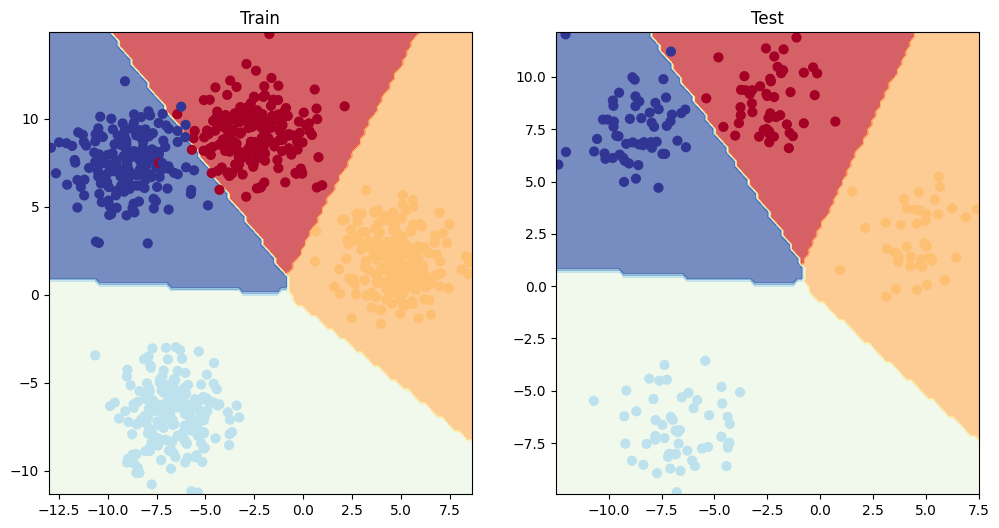

In [18]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model = model_V4,
                        X = X_train,
                        y = Y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model = model_V4,
                        X = X_test,
                        y = Y_test)

#### Classification metrices
* Accuracy: ot of 100 samples , how many does our model get right?
* Precision
* Recall
* F1 - Score
* Confusion matrix
* Classification matrix
We can use both `torch` and `Sklearn` for all of these.

In [21]:
! pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 24.8 MB/s eta 0:00:00


In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

print('Accuracy:', accuracy_score(Y_test, test_pred))
print ('F1 score:', f1_score(Y_test, test_pred,average='macro'))
print ('Recall:', recall_score(Y_test, test_pred,average='macro'))
print ('Precision:', precision_score(Y_test, test_pred,average='macro'))
print ('\n clasification report:\n', classification_report(Y_test, test_pred))
print ('\n confussion matrix:\n',confusion_matrix(Y_test, test_pred))


Accuracy: 0.995
F1 score: 0.9952623580942166
Recall: 0.9956140350877193
Precision: 0.995

 clasification report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        49
         1.0       1.00      1.00      1.00        41
         2.0       1.00      1.00      1.00        53
         3.0       1.00      0.98      0.99        57

    accuracy                           0.99       200
   macro avg       0.99      1.00      1.00       200
weighted avg       1.00      0.99      1.00       200


 confussion matrix:
 [[49  0  0  0]
 [ 0 41  0  0]
 [ 0  0 53  0]
 [ 1  0  0 56]]


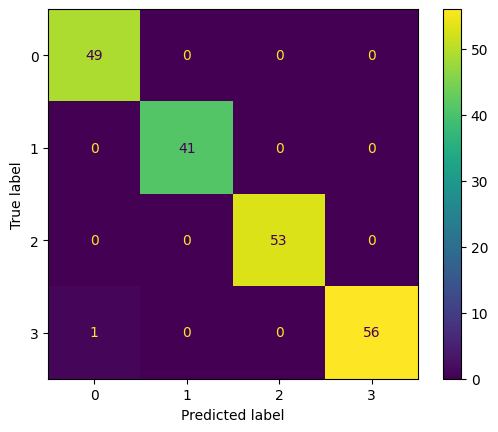

In [29]:
# Optional: Display confusion matrix as a plot
from sklearn.metrics import ConfusionMatrixDisplay
conf_matrix = confusion_matrix(Y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
